In [37]:
# discrete simulation?
discrete_sim = True
# what to plot
dist_stat = "dist"#"stat"#

# import, set directory

colab prep

In [13]:
try:
    import msprime
except ImportError:
    !pip install msprime
    import msprime

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/nmr2ca

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/nmr2ca


In [14]:
# import other packages

import numpy as np
import scipy as sp # for stats
from pathlib import Path
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator as plti
import matplotlib.ticker as pltt

parameters for simulation, set directory

In [15]:
# parameters

# the estimated run time is 20 mins on free colab
[trial_n, subtrial_n] = [10, 1000]
bin_n = 20

# directory
subdirectory = (f"{trial_n:n}x{subtrial_n:n}_"
                + f"{bin_n:n}_{discrete_sim:n}" + "/")
#Path(subdirectory).mkdir()

# simulation

In [38]:
# seqLen*recombRate*popSize, parameter collapse is built in
sample_size_s = [2, 4, 6] # num of individuals
pred_smooth = 10 # factor of extra bins
pred_range = 1.1 # longer than simulated max_time

if dist_stat == "dist":
  rho_s = np.array([3, 30, 300])
  pred_rho_s = rho_s
if dist_stat == "stat":
  rho_s = np.array([3, 10, 30, 100, 300])
  pred_rho_s = np.concatenate(
    [rho_s,
     10. ** np.linspace(
       0, np.log10(np.max(rho_s)*5/3), pred_smooth * bin_n)])

**DON'T RUN, unless have new rhos**

simulation, takes ~5mins for each rho, longer for larger rho

In [39]:
if False:

  [sequence_length, population_size] = [100, 100] # arbitrary
  recomb_rate_s = rho_s / sequence_length / population_size
  ## num of recombinations per base per gen, to have varying combined para
  ploidy = 1 # num of genomes of each individual

  def mrca_time_fct(ts):
    """finding mrca time (over entire sample)"""
    ca_times = np.array([ts.tables.nodes[tree.root].time
                        for tree in ts.trees()])
    return(np.min(ca_times))

  def mrca2_time_fct(ts, sample_size):
    """finding mrca2 time (any two in sample)
    only coalescences create nodes when record_full_arg = False,
    node 0 to samp_n-1 label the sample, so samp_n labels the first coalescence"""
    return(ts.tables.nodes[sample_size].time)

  # loop
  for sample_size in sample_size_s:
    for recomb_rate_idx, recomb_rate in enumerate(recomb_rate_s):
      temp_mrca_time_s= np.zeros((trial_n, subtrial_n))
      for trial_idx in range(trial_n):
        for sub_trial_idx in range(subtrial_n):
          temp_ts = msprime.sim_ancestry(
            samples = sample_size,
            ploidy = ploidy,
            recombination_rate = recomb_rate,
            sequence_length = sequence_length,
            population_size = population_size,
            record_full_arg = False, # False when using mrca2
            discrete_genome = discrete_sim)
          # temp_mrca_time_s[trial_idx, sub_trial_idx] = (
          #   mrca_time_fct(temp_ts) / population_size)
          temp_mrca_time_s[trial_idx, sub_trial_idx] = (
            mrca2_time_fct(temp_ts, sample_size) / population_size)
      np.savez_compressed(
        subdirectory + "{:n}-{:n}.npz".format(
          sample_size,
          rho_s[recomb_rate_idx]),
        temp_mrca_time_s)

# analysis

get histograms

In [40]:
#loading
def load_as_list(zipname, allow_pickle = False):
  return([np.load(zipname, allow_pickle = allow_pickle)[array_name]
          for array_name in np.load(zipname, allow_pickle = allow_pickle).files])

#load
all_mrca_time_s = [
  [load_as_list(subdirectory + "{:n}-{:n}.npz".format(
     sample_size, rho))[0]
   for rho in rho_s]
  for sample_size in sample_size_s]

# hist
all_mrca_time_s = np.expand_dims(np.array(all_mrca_time_s), 4)
max_time_s = np.max(all_mrca_time_s, axis = (2, 3), keepdims = True)
bin_edge_s = np.arange(bin_n+1) / (bin_n-0.05) * max_time_s # to include max_t
bin_s = (bin_edge_s[:, :, 0, 0, 1:] + bin_edge_s[:, :, 0, 0, :-1]) / 2
mrca_hist_s = np.sum(
  (bin_edge_s[..., :-1] <= all_mrca_time_s).astype(int)
  * (all_mrca_time_s < bin_edge_s[..., 1:]).astype(int),
  axis = 3) / subtrial_n / (bin_edge_s[:,:,:,0,1:] - bin_edge_s[:,:,:,0,:-1])
mrca_dist_s = [stat(mrca_hist_s, axis = 2) for stat in [np.mean, sp.stats.sem]]

# #hist
# all_mrca_time_s = np.expand_dims(np.array(all_mrca_time_s), 4)
# max_time_s = np.max(all_mrca_time_s, axis = (2, 3, 4), keepdims = True)
# bin_edge_s = (np.arange(bin_n + 1) / (bin_n + 1) * max_time_s)
# bin_s = (bin_edge_s[:, :, 0, 0, 1:] + bin_edge_s[:, :, 0, 0, :-1]) / 2
# mrca_hist_s = np.sum((bin_edge_s[..., :-1] <= all_mrca_time_s).astype(int)
#                      * (all_mrca_time_s < bin_edge_s[..., 1:]).astype(int),
#                      axis = 3) / subtrial_n / (max_time_s[..., 0] / bin_n)
# mrca_dist_s = [stat(mrca_hist_s, axis = 2) for stat in [np.mean, sp.stats.sem]]

predictions

In [41]:
(pred_rho_s).shape

(3,)

In [42]:
samp_n_n = len(sample_size_s)

# estimate "support" of distributions for unsimulated rhos
pred_max_time_s = [pred_rho_s for samp_n_idx in range(samp_n_n)]
for samp_n_idx in range(samp_n_n):
  # linear interpolation
  temp_x = np.log(rho_s)
  temp_y = np.log(max_time_s[samp_n_idx, :, 0, 0, 0])
  pred_max_time_s[samp_n_idx] = np.exp(
    temp_y[0]
    + ((temp_y[-1] - temp_y[0]) / (temp_x[-1] - temp_x[0])
       * (np.log(pred_rho_s)- temp_x[0])))
pred_max_time_s = np.array(pred_max_time_s) * pred_range
pred_bin_n = pred_smooth * bin_n

# independent variables
iv_n = np.expand_dims(sample_size_s, (1, 2))
iv_nu = (iv_n * (iv_n - 1) / 2)
iv_r = np.expand_dims(pred_rho_s, (0, 2))
iv_t = np.transpose(
    np.linspace(0, pred_max_time_s, pred_bin_n+1),
     (1, 2, 0))

# survival functions
f_ref = np.exp(-iv_nu * iv_t)
f_smc = np.exp(
  -iv_nu * iv_t
  - iv_n * iv_r * (
    iv_t - (1 - np.exp(-(iv_n - 1) * iv_t)) / (iv_n - 1)))
f_smcp = np.exp(
  -iv_nu * iv_t
  - (iv_n - 1) * iv_r * (
    iv_t - (1 - np.exp(-iv_n * iv_t)) / iv_n))
f_smc_d = np.exp(-iv_nu * iv_t * (iv_r * iv_t + 1))
f_smcp_d = np.exp(-iv_nu * (
  (2 * iv_r + 1) * iv_t - 2 * iv_r * (1 - np.exp(-iv_t))))

#pdfs
[ref, smc, smcp, smc_d, smcp_d] = [
  -np.gradient(s_f, axis = -1) / (iv_t[:, :, 1:2] - iv_t[:, :, 0:1])
  for s_f in [f_ref, f_smc, f_smcp, f_smc_d, f_smcp_d]]

find stats

In [43]:
# simulated
# mrca_time_mean_s = (np.sum(np.expand_dims(bin_s, 2) * mrca_hist_s, axis = 3)
#                     * max_time_s[..., 0, 0] / bin_n)
# mrca_time_std_s = np.sqrt((np.sum(np.expand_dims(bin_s, 2) ** 2 * mrca_hist_s, axis = 3)
#                            * max_time_s[..., 0, 0] / bin_n)
#                           - mrca_time_mean_s ** 2)
mrca_time_mean_s = np.mean(all_mrca_time_s, axis = (3,4))
mrca_time_std_s = np.std(all_mrca_time_s, axis = (3,4))
mrca_time_stat_s = [mrca_time_mean_s, mrca_time_std_s]
mrca_time_stat_s_stat_s = [[stat(mrca_time_stat_s[stat_idx], axis = 2)
                            for stat in [np.mean, sp.stats.sem]]
                           for stat_idx in range(2)]

# predictions
def mean_std_helper(pred):
  mean = (np.sum(iv_t * pred, axis = 2)
          * pred_max_time_s / pred_bin_n)
  var = ((np.sum(iv_t ** 2 * pred, axis = 2)
          * pred_max_time_s / pred_bin_n)
         - mean ** 2)
  return([mean, np.sqrt(var)])

ref_stat_s = [np.squeeze(1 / (iv_n * (iv_n - 1) / 2) + 0 * iv_r)
              for stat_idx in range(2)]
asymp_stat_s = [
  np.squeeze(np.sqrt(np.pi / (iv_n * (iv_n - 1) / 2) / iv_r) / 2),
  np.squeeze(np.sqrt((4 - np.pi) / 4 / (iv_n * (iv_n - 1) / 2) / iv_r))]
[smc_stat_s, smcp_stat_s, smc_d_stat_s, smcp_d_stat_s] = [
  mean_std_helper(dist) for dist in [smc, smcp, smc_d, smcp_d]]

# %error
rho_n = len(rho_s)

def stat_err_s_fct(pred_stat_s):
  return([[stat((np.expand_dims(pred_stat_s[stat_idx][:, :rho_n], 2)
                 - mrca_time_stat_s[stat_idx])
                / mrca_time_stat_s[stat_idx], axis = 2)
           for stat in [np.mean, sp.stats.sem]]
          for stat_idx in range(2)])

[ref_stat_err_s, asymp_stat_err_s,
 smc_stat_err_s, smcp_stat_err_s, smc_d_stat_err_s, smcp_d_stat_err_s] = [
  stat_err_s_fct(stat_s)
  for stat_s
  in [ref_stat_s, asymp_stat_s,
      smc_stat_s, smcp_stat_s, smc_d_stat_s, smcp_d_stat_s]]

# plot

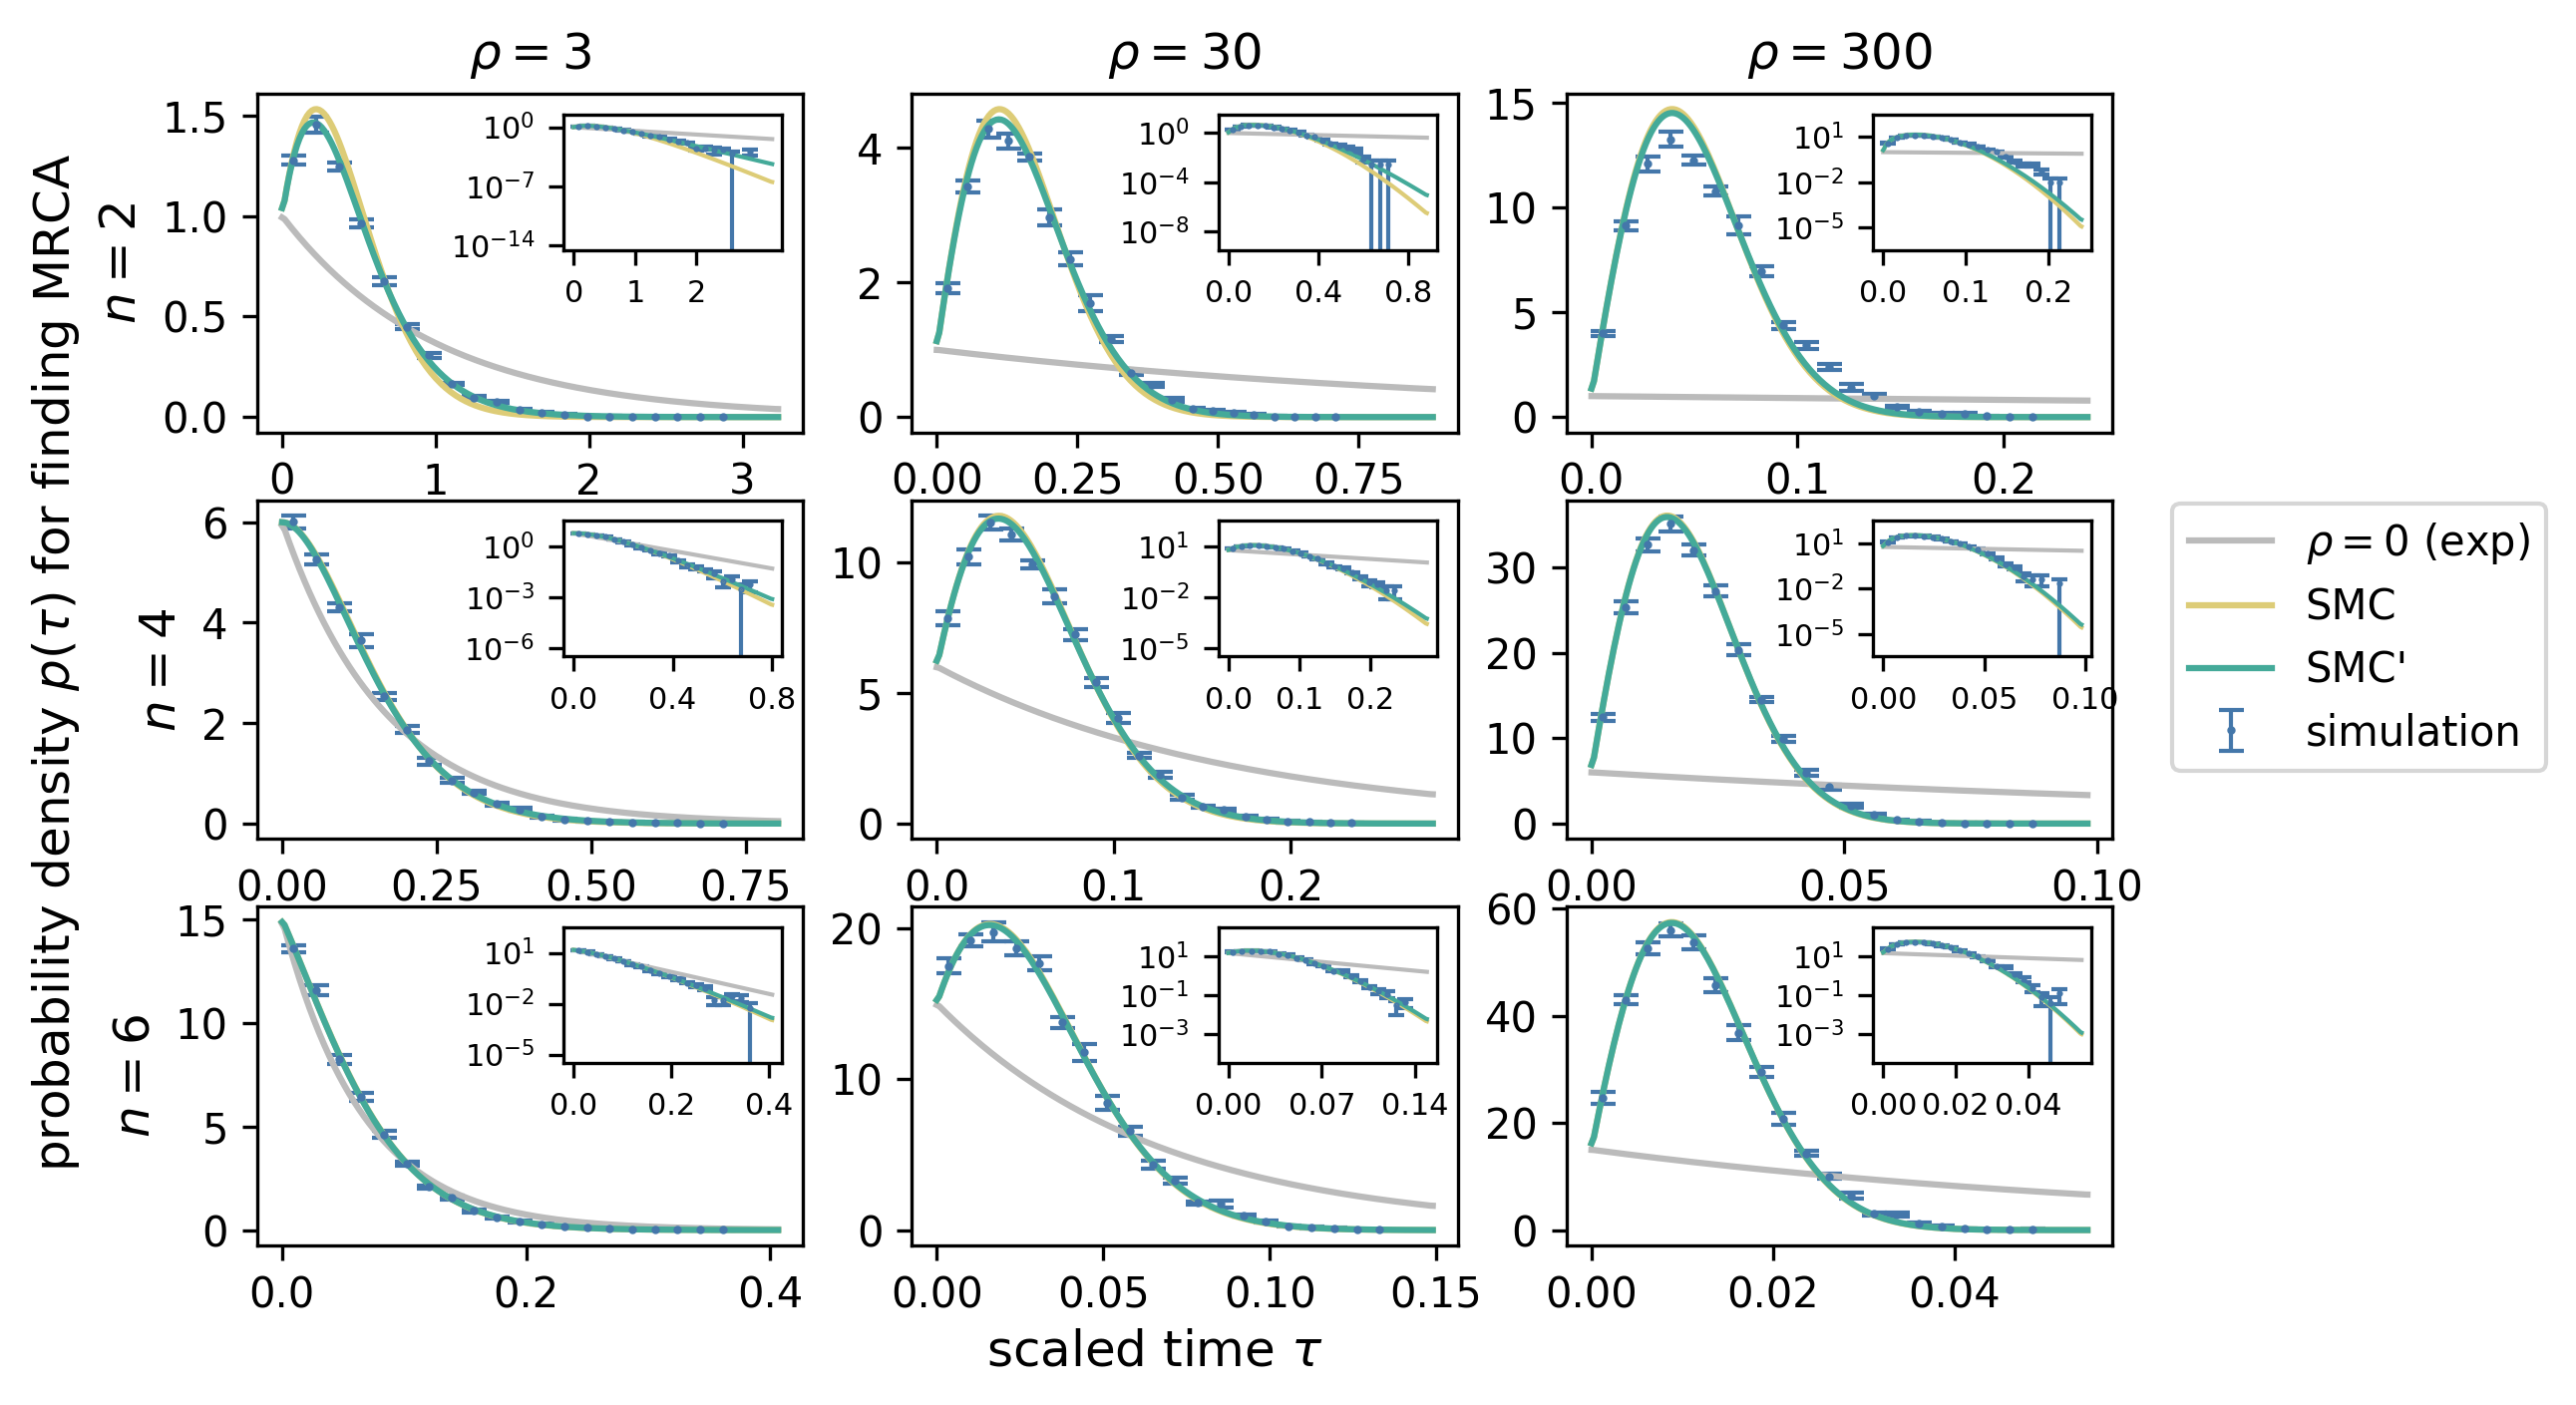

In [44]:
if dist_stat=="dist":

  color_s = np.array([
    [187, 187, 187],
    [68, 119, 170], [153, 153, 51], [17, 119, 51], [170, 51, 119],
    [204, 102, 119], [68, 170, 153], [221, 204, 119], [136, 204, 238]]) / 255

  rho_n = len(rho_s)

  [fig, subfig_s] = plt.subplots(samp_n_n, rho_n,
                                squeeze = False, figsize = (8, 5), dpi = 300)
  for samp_n_idx in range(samp_n_n):
    for rho_idx in range(rho_n):
      # subfig_s[samp_n_idx, rho_idx].plot(
      #   bin_s[samp_n_idx][rho_idx], mrca_hist_s[samp_n_idx][rho_idx].T,
      #   color = color_s[-1], linestyle = "", marker = ".", markersize = 1,
      #   label = "scattered sim.")
      subfig_s[samp_n_idx, rho_idx].errorbar(
        bin_s[samp_n_idx][rho_idx], mrca_dist_s[0][samp_n_idx][rho_idx],
        yerr = mrca_dist_s[1][samp_n_idx][rho_idx],
        color = color_s[1], linestyle = "", marker = ".",
        markersize = 2, capsize = 3, elinewidth=1,
        label = "simulation")
      subfig_s[samp_n_idx, rho_idx].plot(
        iv_t[samp_n_idx][rho_idx], ref[samp_n_idx][rho_idx],
        color = color_s[0], linewidth = 1.5,
        label = r"$\rho=0$ (exp)") # r"$\rho\ll n^2$ (exp)"
      subfig_s[samp_n_idx, rho_idx].plot(
        iv_t[samp_n_idx][rho_idx], smc[samp_n_idx][rho_idx],
        color = color_s[-2], linewidth = 1.5,
        label = "SMC")
      subfig_s[samp_n_idx, rho_idx].plot(
        iv_t[samp_n_idx][rho_idx], smcp[samp_n_idx][rho_idx],
        color = color_s[-3], linewidth = 1.5,
        label = "SMC'")
      # subfig_s[samp_n_idx, rho_idx].plot(
      #   iv_t[samp_n_idx][rho_idx], smc_d[samp_n_idx][rho_idx],
      #   color = color_s[2], linestyle = (0,(1,1)), linewidth = 1.5,
      #   label = r"SMC$_{\mathregular{d}}$")
      # subfig_s[samp_n_idx, rho_idx].plot(
      #   iv_t[samp_n_idx][rho_idx], smcp_d[samp_n_idx][rho_idx],
      #   color = color_s[3], linestyle = (0,(1,1)), linewidth = 1.5,
      #   label = r"SMC'$_{\mathregular{d}}$")


  # order of magnitude
  def oom_fct(iv):
    return(np.floor(np.log10(np.abs(iv))).astype(int))
  def oom_round(iv, type = 0):
    sign = np.sign(iv)
    if type == 0:
      round = np.round
    elif type > 0:
      round = np.ceil
    elif type < 0:
      round = np.floor
    return(sign * round(np.abs(iv) / 10. ** oom_fct(iv)) * 10. ** oom_fct(iv))

  for samp_n_idx in range(samp_n_n):
    for rho_idx in range(rho_n):
      temp_inset = plti.inset_axes(subfig_s[samp_n_idx, rho_idx],
                                  width = "40%", height = "40%")
      # temp_inset.plot(
      #   bin_s[samp_n_idx][rho_idx], mrca_hist_s[samp_n_idx][rho_idx].T,
      #   color = color_s[-1], linestyle = "", marker = ".", markersize = 1)
      temp_inset.errorbar(
        bin_s[samp_n_idx][rho_idx], mrca_dist_s[0][samp_n_idx][rho_idx],
        yerr = mrca_dist_s[1][samp_n_idx][rho_idx],
        color = color_s[1], linestyle = "", marker = ".",
        markersize = 1, capsize = 2, elinewidth = 1)
      temp_inset.plot(
        iv_t[samp_n_idx][rho_idx], ref[samp_n_idx][rho_idx],
        color = color_s[0], linewidth = 1)
      temp_inset.plot(
        iv_t[samp_n_idx][rho_idx], smc[samp_n_idx][rho_idx],
        color = color_s[-2], linewidth = 1)
      temp_inset.plot(
        iv_t[samp_n_idx][rho_idx], smcp[samp_n_idx][rho_idx],
        color = color_s[-3], linewidth = 1)
      # temp_inset.plot(
      #   iv_t[samp_n_idx][rho_idx], smc_d[samp_n_idx][rho_idx],
      #   color = color_s[2], linestyle = (0,(1,1)), linewidth = 1)
      # temp_inset.plot(
      #   iv_t[samp_n_idx][rho_idx], smcp_d[samp_n_idx][rho_idx],
      #   color = color_s[3], linestyle = (0,(1,1)), linewidth = 1)
      temp_inset.set(yscale = "log")
      temp_ylim = np.array([np.min(smc_d[samp_n_idx][rho_idx]), # ylim
                            np.max(smc_d[samp_n_idx][rho_idx])])
      temp_ylim_oom = oom_fct(temp_ylim)
      temp_ylim = 10. ** (temp_ylim_oom + np.array([-0.5, 1.5]))
      temp_inset.set_ylim(temp_ylim[0], temp_ylim[1])
      temp_ytick_oom_sep = (temp_ylim_oom[1] - temp_ylim_oom[0]) // 2 # yticks
      temp_ytick_s = 10. ** (temp_ylim_oom[1]
                            + np.arange(-2, 1) * temp_ytick_oom_sep)
      temp_inset.set_yticks(temp_ytick_s)
      temp_xlim_max = temp_inset.get_xlim()[1] # xticks
      temp_xtick_sep = oom_round(temp_xlim_max / 2, type = -1)
      temp_xtick_s = np.arange(3) * temp_xtick_sep
      temp_inset.set_xticks(temp_xtick_s)
      temp_inset.tick_params(axis='both', labelsize = 7.3)

  for samp_n_idx in range(samp_n_n):
    subfig_s[samp_n_idx, 0].set_ylabel(
      r"$n=${:n}".format(sample_size_s[samp_n_idx]), fontsize = 12)
  for rho_idx in range(rho_n):
    subfig_s[0, rho_idx].set(
      title = r"$\rho=${:n}".format(rho_s[rho_idx]))
  fig.text(0.5, 0.03,
          r"scaled time $\tau$",
          ha = "center", fontsize = 12);
  fig.text(0.03, 0.5,
          r"probability density $p(\tau)$ for finding MRCA",
          va = "center", rotation = "vertical", fontsize = 12);

  [handle, label] = subfig_s[0, 0].get_legend_handles_labels()
  # handle = [handle[artist_idx] for artist_idx in range(-6, 0)]
  # label = [label[artist_idx] for artist_idx in range(-6, 0)]
  handle = [handle[artist_idx] for artist_idx in range(-4, 0)]
  label = [label[artist_idx] for artist_idx in range(-4, 0)]
  fig.legend(handle, label, bbox_to_anchor=(1.09, 0.62));

  fig.savefig('figs/distributions.pdf', bbox_inches = 'tight')

## for stats plot

plot

In [45]:
if dist_stat=="stat":

  color_s = np.array([
    [187, 187, 187],
    [68, 119, 170], [153, 153, 51], [17, 119, 51], [170, 51, 119],
    [204, 102, 119], [68, 170, 153], [221, 204, 119], [136, 204, 238]]) / 255


  [fig, subfig_s] = plt.subplots(samp_n_n, 2,
                                squeeze = False, figsize = (8, 5), dpi = 300)
  for samp_n_idx in range(samp_n_n):
    for stat_idx in range(2):
      # subfig_s[samp_n_idx, stat_idx].plot(
      #   rho_s, mrca_time_stat_s[stat_idx][samp_n_idx],
      #   color = color_s[-1], linestyle = "", marker = ".", markersize = 1,
      #   label = "scattered sim.")
      subfig_s[samp_n_idx, stat_idx].errorbar(
        rho_s, mrca_time_stat_s_stat_s[stat_idx][0][samp_n_idx],
        yerr = mrca_time_stat_s_stat_s[stat_idx][1][samp_n_idx],
        color = color_s[1], linestyle = "", marker = ".",
        markersize = 4, capsize = 3, elinewidth=1,
        label = "simulation")
      subfig_s[samp_n_idx, stat_idx].plot(
        pred_rho_s[rho_n:], ref_stat_s[stat_idx][samp_n_idx, rho_n:],
        color = color_s[0], linewidth = 1,
        label = r"$\rho=0$ (exp)") # r"$\rho\ll n^2$ (exp)"
      subfig_s[samp_n_idx, stat_idx].plot(
        pred_rho_s[rho_n:], asymp_stat_s[stat_idx][samp_n_idx, rho_n:],
        color = "black", linewidth = 1,
        label = r"$\rho\gg n^2$")
      subfig_s[samp_n_idx, stat_idx].plot(
        pred_rho_s[rho_n:], smc_stat_s[stat_idx][samp_n_idx, rho_n:],
        color = color_s[-2], linewidth = 1.5,
        label = "SMC")
      subfig_s[samp_n_idx, stat_idx].plot(
        pred_rho_s[rho_n:], smcp_stat_s[stat_idx][samp_n_idx, rho_n:],
        color = color_s[-3], linewidth = 1.5,
        label = "SMC'")
      # subfig_s[samp_n_idx, stat_idx].plot(
      #   pred_rho_s[rho_n:], smc_d_stat_s[stat_idx][samp_n_idx, rho_n:],
      #   color = color_s[2], linestyle = (0,(1,1)), linewidth = 1.5,
      #   label = r"SMC$_{\mathregular{d}}$")
      # subfig_s[samp_n_idx, stat_idx].plot(
      #   pred_rho_s[rho_n:], smcp_d_stat_s[stat_idx][samp_n_idx, rho_n:],
      #   color = color_s[3], linestyle = (0,(1,1)), linewidth = 1.5,
      #   label = r"SMC'$_{\mathregular{d}}$")
      temp_xlim = subfig_s[samp_n_idx, stat_idx].get_xlim()
      temp_xlim = (
        10. ** (np.log10(np.min(pred_rho_s)) * 0.95),
        10. ** (np.log10(np.max(pred_rho_s)) * 1.05))
      subfig_s[samp_n_idx, stat_idx].set(
        xscale = "log", yscale = "log",
        xlim = temp_xlim,
        xticks = rho_s, xticklabels = rho_s)
      temp_ylim = subfig_s[samp_n_idx, stat_idx].get_ylim() # yticks
      temp_ylim_oom = np.round(np.mean(np.log10(np.array(temp_ylim))))
      temp_ytick_s = np.array([0.2, 0.5, 1, 2, 5]) * 10. ** temp_ylim_oom
      temp_ytick_s_minor = (np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                      1, 2, 3, 4, 5, 6, 7, 8, 9])
                            * 10. ** temp_ylim_oom)
      temp_ytick_s = temp_ytick_s[(temp_ytick_s > temp_ylim[0])
                                  & (temp_ytick_s < temp_ylim[1])]
      temp_ytick_s_minor = temp_ytick_s_minor[
        (temp_ytick_s_minor > temp_ylim[0]) & (temp_ytick_s_minor < temp_ylim[1])]
      subfig_s[samp_n_idx, stat_idx].set(
        yticks = temp_ytick_s, yticklabels = temp_ytick_s)
      subfig_s[samp_n_idx, stat_idx].yaxis.set_major_formatter(
        pltt.StrMethodFormatter('{x:.2f}'))
      subfig_s[samp_n_idx, stat_idx].set_yticks(temp_ytick_s_minor, minor=True)
      subfig_s[samp_n_idx, stat_idx].set_yticklabels('', minor=True)

  # order of magnitude
  def oom_fct(iv):
    return(np.floor(np.log10(np.abs(iv))).astype(int))
  def oom_round(iv, type = 0):
    sign = np.sign(iv)
    if type == 0:
      round = np.round
    elif type > 0:
      round = np.ceil
    elif type < 0:
      round = np.floor
    return(sign * round(np.abs(iv) / 10. ** oom_fct(iv)) * 10. ** oom_fct(iv))

  for samp_n_idx in range(samp_n_n):
    for stat_idx in range(2):
      temp_inset = plti.inset_axes(subfig_s[samp_n_idx, stat_idx],
                                  width = "35%", height = "40%")
      temp_inset.errorbar(
        rho_s, ref_stat_err_s[stat_idx][0][samp_n_idx],
        yerr = ref_stat_err_s[stat_idx][1][samp_n_idx],
        color = color_s[0], linewidth = 0.7,
        marker = ".", markersize = 3, capsize = 2, elinewidth = 1)
      temp_inset.errorbar(
        rho_s, asymp_stat_err_s[stat_idx][0][samp_n_idx],
        yerr = asymp_stat_err_s[stat_idx][1][samp_n_idx],
        color = "black", linewidth = 0.7,
        marker = ".", markersize = 3, capsize = 2, elinewidth = 1)
      temp_inset.errorbar(
        rho_s, smc_stat_err_s[stat_idx][0][samp_n_idx],
        yerr = smc_stat_err_s[stat_idx][1][samp_n_idx],
        color = color_s[-2], linewidth = 1,
        marker = ".", markersize = 3, capsize = 2, elinewidth = 1)
      temp_inset.errorbar(
        rho_s, smcp_stat_err_s[stat_idx][0][samp_n_idx],
        yerr = smcp_stat_err_s[stat_idx][1][samp_n_idx],
        color = color_s[-3], linewidth = 1,
        marker = ".", markersize = 3, capsize = 2, elinewidth = 1)
      # temp_inset.errorbar(
      #   rho_s, smc_d_stat_err_s[stat_idx][0][samp_n_idx],
      #   yerr = smc_d_stat_err_s[stat_idx][1][samp_n_idx],
      #   color = color_s[2], linestyle = (0,(1,1)), linewidth = 1,
      #   marker = ".", markersize = 3, capsize = 2, elinewidth = 1)
      # temp_inset.errorbar(
      #   rho_s, smcp_d_stat_err_s[stat_idx][0][samp_n_idx],
      #   yerr = smcp_d_stat_err_s[stat_idx][1][samp_n_idx],
      #   color = color_s[3], linestyle = (0,(1,1)), linewidth = 1,
      #   marker = ".", markersize = 3, capsize = 2, elinewidth = 1)
      temp_xlim = temp_inset.get_xlim()
      temp_xlim = (
        10. ** (np.log10(np.min(rho_s)) * 0.8),
        10. ** (np.log10(np.max(rho_s)) * 1.05))
      temp_inset.set(xscale = "log", xticks = rho_s, xlim = temp_xlim, xticklabels = rho_s)
      temp_inset.tick_params(axis='both', labelsize = 7.5)
      temp_ylim = (
        np.min(smc_d_stat_err_s[stat_idx][0][samp_n_idx])
        * np.array([1.1, -0.2]))
      # temp_ylim = np.array(
      #   [temp_ylim[0], np.maximum(
      #     temp_ylim[1], asymp_stat_err_s[stat_idx][0][samp_n_idx][-2]) * 1.1])
      temp_ytick_sep = oom_round(np.abs(temp_ylim[0]) / 2, type = -1)
      temp_ytick_s = np.arange(-2, 1) * temp_ytick_sep
      temp_inset.set_ylim(temp_ylim)
      temp_inset.set_yticks(temp_ytick_s)
      temp_inset.hlines(0, rho_s[0], rho_s[-1],
                        color = "black", linewidth = 0.3)

  for samp_n_idx in range(samp_n_n):
    subfig_s[samp_n_idx, 0].set_ylabel(
      r"$n=${:n}".format(
        sample_size_s[samp_n_idx]), fontsize = 12)
  subfig_s[0, 0].set(title = "mean TMRCA\ninset: %error")
  subfig_s[0, 1].set(title = "std of TMRCA\ninset: %error")
  fig.text(0.5, 0.03,
          r"scaled map length $\rho$",
          ha = "center", fontsize = 12);
  fig.text(0.02, 0.5,
          r"sample size",
          va = "center", rotation = "vertical", fontsize = 12);

  [handle, label] = subfig_s[0, 0].get_legend_handles_labels()
  # handle = [handle[artist_idx] for artist_idx in range(-7, 0)]
  # label = [label[artist_idx] for artist_idx in range(-7, 0)]
  handle = [handle[artist_idx] for artist_idx in range(-5, 0)]
  label = [label[artist_idx] for artist_idx in range(-5, 0)]
  fig.legend(handle, label, bbox_to_anchor=(1.11, 0.65));

  fig.savefig('figs/stats.pdf', bbox_inches = 'tight')

# length vs T

╔══╤═════╤══════════╤══════════╤════════════╤════════╗
║id│flags│population│individual│time        │metadata║
╠══╪═════╪══════════╪══════════╪════════════╪════════╣
║0 │    1│         0│         0│  0.00000000│        ║
║1 │    1│         0│         1│  0.00000000│        ║
║2 │    0│         0│        -1│ 57.65973419│        ║
║3 │    0│         0│        -1│ 58.98011923│        ║
║4 │    0│         0│        -1│135.32596870│        ║
║5 │    0│         0│        -1│159.70160245│        ║
║6 │    0│         0│        -1│304.44005346│        ║
╚══╧═════╧══════════╧══════════╧════════════╧════════╝



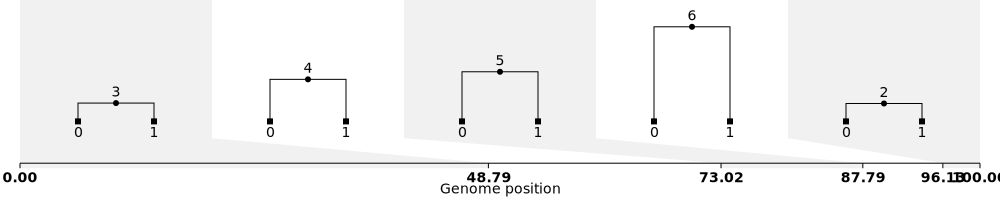

In [ ]:
import msprime
from IPython.display import SVG

[sequence_length, population_size] = [100, 100] # arbitrary
recomb_rate_s = rho_s / sequence_length / population_size
## num of recombinations per base per gen, to have varying combined para
ploidy = 1

temp_ts = msprime.sim_ancestry(
          samples = sample_size_s[0],
          ploidy = ploidy,
          recombination_rate = recomb_rate_s[0],
          sequence_length = sequence_length,
          population_size = population_size,
          record_full_arg = False,
          discrete_genome = False)

print(temp_ts.tables.nodes)
SVG(temp_ts.draw_svg())

In [ ]:
import msprime

def mrca2_time_fct(ts, sample_size):
  """finding mrca2 time (any two in sample)"""
  # when ts has record_full_arg = False,
  # only coalescence has nodes
  # 0 to samp_n-1 label the sample,
  # so samp_n labels the first coalescence
  return(ts.tables.nodes[sample_size].time)

new_recomb_rate_s = np.append(recomb_rate_s, 0.1)

# loop
temp_mrca_time_s= np.zeros((len(new_recomb_rate_s), subtrial_n*10))
segment_len_s = np.zeros((len(new_recomb_rate_s), subtrial_n*10))
for sample_size in sample_size_s[:1]:
  for recomb_rate_idx, recomb_rate in enumerate(new_recomb_rate_s):
    for sub_trial_idx in range(subtrial_n*10):
      temp_ts = msprime.sim_ancestry(
        samples = sample_size,
        ploidy = ploidy,
        recombination_rate = recomb_rate,
        sequence_length = sequence_length,
        population_size = population_size,
        record_full_arg = False, # True only works for mrca not mrca2
        discrete_genome = False)
      temp_mrca_time_s[recomb_rate_idx, sub_trial_idx] = (
        mrca2_time_fct(temp_ts, sample_size) / population_size)
      edge = [edge for edge in temp_ts.edges() if edge.parent == sample_size][0]
      segment_len_s[recomb_rate_idx, sub_trial_idx] = edge.right - edge.left

[Text(0.5, 0, 'TMRCA')]

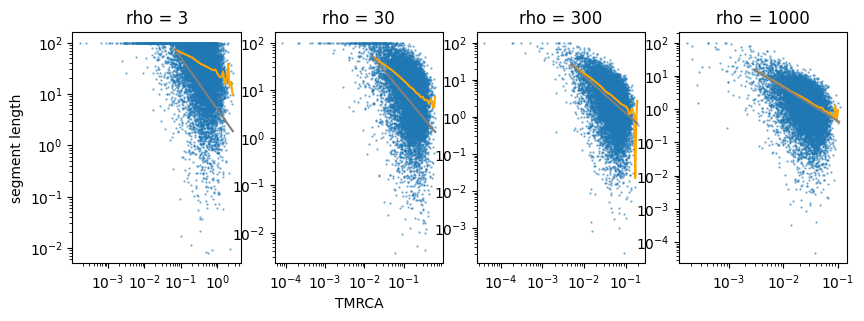

In [ ]:
import matplotlib.pyplot as plt

fig, ax_s = plt.subplots(1, len(new_recomb_rate_s), figsize = (10, 3))
for recomb_rate_idx, recomb_rate in enumerate(new_recomb_rate_s):
  temp_mrca_time = temp_mrca_time_s[recomb_rate_idx]
  segment_len = segment_len_s[recomb_rate_idx]
  ax_s[recomb_rate_idx].scatter(temp_mrca_time, segment_len, s = 0.5,alpha=0.5);
  bins = np.linspace(np.min(temp_mrca_time), np.max(temp_mrca_time), 21)
  bin_centers = 0.5 * (bins[:-1] + bins[1:])
  bin_indices = np.digitize(temp_mrca_time, bins) - 1
  means = np.array([segment_len[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan
                    for i in range(len(bins)-1)])
  ax_s[recomb_rate_idx].plot(bin_centers, means, color = "orange")
  ax_s[recomb_rate_idx].plot(bin_centers, means[0]*bin_centers[0]/bin_centers, color = "gray")
  ax_s[recomb_rate_idx].set(xscale = "log", yscale = "log", )
  ax_s[recomb_rate_idx].set(title = f"rho = {recomb_rate*sequence_length*population_size:n}")
ax_s[0].set(ylabel = "segment length")
ax_s[1].set(xlabel = "TMRCA")